In [36]:
!pwd

/home/ubuntu


In [1]:
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
from src.datasets.loading import statcan, ookla

## Basic Plotting of Tiles + Statistics Canda Shapefiles
To show some utility and make a graph where you can actually see the tiles individually, 
below is an example of some of the things you can do with GeoPandas.

In [39]:
## Statcan Data: list names of available shapefiles
statcan.boundary_names()

['provinces',
 'provinces_digital',
 'federal_electoral_districts_2013_representation_order',
 'economic_regions',
 'census_divisions',
 'population_centres',
 'population_ecumene',
 'dissemination_areas',
 'dissemination_blocks',
 'census_subdivisions',
 'designated_places',
 'lakes_and_rivers_polygons']

In [3]:
speed_tiles = ookla.canada_speed_tiles().loc[lambda s:(s.quarter==1) & (s.year==2022)]

In [41]:
type(speed_tiles)

geopandas.geodataframe.GeoDataFrame

In [42]:
speed_tiles.head(3)

,quadkey,geometry,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,conn_type,year,quarter
12,302303331012303,"POLYGON ((-73.36121 45.53329, -73.35571 45.533...",263271,40226,12,7,5,fixed,2022,1
31,212122230130321,"POLYGON ((-122.75574 49.30364, -122.75024 49.3...",222178,158924,8,117,39,fixed,2022,1
38,212122230130321,"POLYGON ((-122.75574 49.30364, -122.75024 49.3...",120847,23082,17,6,1,mobile,2022,1


In [43]:
speed_tiles['quarter'].unique()

array([1])

In [44]:
statcan.boundary('population_centres')

,PCUID,PCNAME,PCTYPE,PCPUID,PCCLASS,PRUID,PRNAME,CMAUID,CMANAME,CMATYPE,CMAPUID,geometry
0,0300,Fortune,4,100300,2,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,None,None,None,None,"POLYGON ((8814306.340 1975116.377, 8814294.583..."
1,0311,Gander,1,100311,2,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,011,Gander,D,10011,"POLYGON ((8774241.249 2203304.440, 8774340.869..."
2,0329,Grand Bank,4,100329,2,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,None,None,None,None,"POLYGON ((8817881.080 1980819.671, 8817890.063..."
3,0332,Grand Falls-Windsor,1,100332,2,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,010,Grand Falls-Windsor,D,10010,"POLYGON ((8713608.417 2159194.443, 8713536.711..."
4,0994,Wabana,4,100994,2,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,None,None,None,None,"POLYGON ((8960434.160 2150870.983, 8960420.171..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1392,Cambridge Bay,4,621392,2,62,Nunavut,None,None,None,None,"POLYGON ((5693087.300 3673041.714, 5693078.646..."
1006,1393,Arviat,4,621393,2,62,Nunavut,None,None,None,None,"POLYGON ((6086430.914 2754980.477, 6086670.566..."
1007,1439,Baker Lake,4,621439,2,62,Nunavut,None,None,None,None,"POLYGON ((6005638.106 3107769.754, 6005661.523..."
1008,1440,Kugluktuk,4,621440,2,62,Nunavut,None,None,None,None,"POLYGON ((5270072.754 3651463.446, 5270060.754..."


### Canada

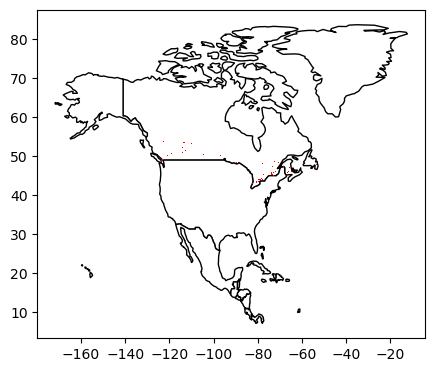

In [45]:
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))

# We restrict to North America.
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
speed_tiles.plot(ax=ax, color='red')

plt.show()

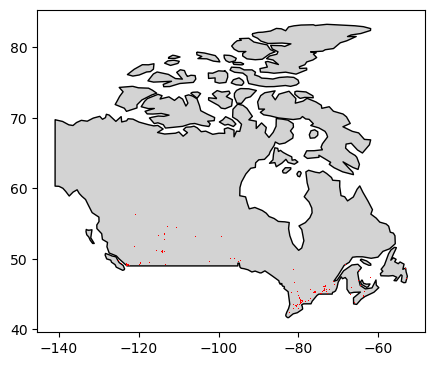

In [46]:
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))

# We restrict to Canada.
ax = world[world.name == 'Canada'].plot(
    color='lightgrey', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
speed_tiles.plot(ax=ax, color='red')

plt.show()

### Fixed vs Mobile

In [47]:
speed_tiles_fixed = speed_tiles.loc[lambda s:(s.conn_type == "fixed")]
speed_tiles_mobile = speed_tiles.loc[lambda s:(s.conn_type == "mobile")]

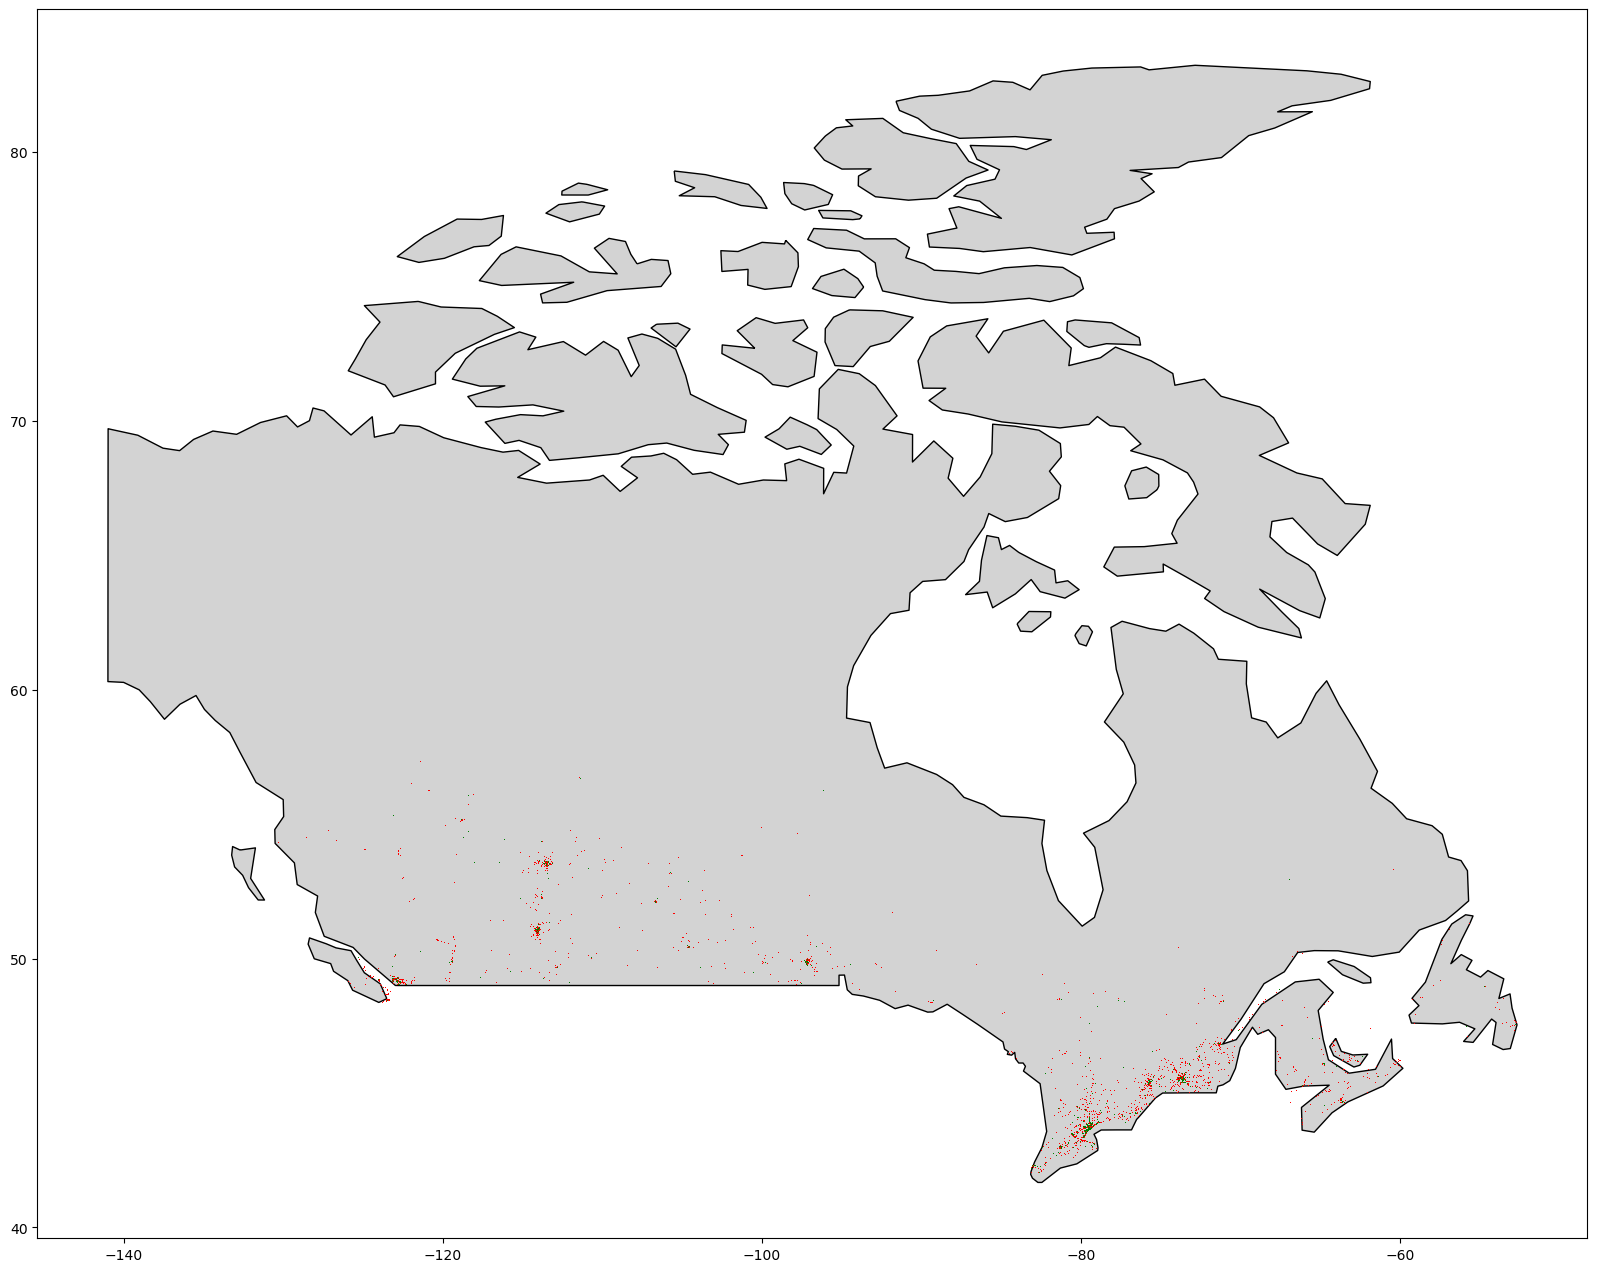

In [64]:
plt.rcParams["figure.figsize"] = (20,20)

world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))

# We restrict to Canada.
ax = world[world.name == 'Canada'].plot(
    color='lightgrey', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
speed_tiles_fixed.plot(ax=ax, color='red')
speed_tiles_mobile.plot(ax=ax, color='green')


plt.show()

### Edmonton Area

In [4]:
#Use a buffer to increase Edmonton size, envelope creates a bounding box for use later.
edmonton_area = statcan.boundary('population_centres').loc[lambda s:s.PCNAME=='Edmonton'].copy()
edmonton_area.geometry = edmonton_area.buffer(50000).envelope #The StatCan CRS is in units of meters, so this is all tiles within 50 km of Edmonton

In [5]:
nearby_census_subdivs = statcan.boundary('census_subdivisions').sjoin(edmonton_area[['PCNAME','PCTYPE','PCCLASS','geometry']], how='inner')
del nearby_census_subdivs['index_right']
nearby_census_subdivs.sample(3)

,CSDUID,CSDNAME,CSDTYPE,PRUID,PRNAME,CDUID,CDNAME,CDTYPE,CCSUID,CCSNAME,...,SACCODE,SACTYPE,CMAUID,CMAPUID,CMANAME,CMATYPE,geometry,PCNAME,PCTYPE,PCCLASS
4103,4811005,Poplar Bay,SV,48,Alberta,4811,Division No. 11,CDR,4811001,Wetaskiwin County No. 10,...,999,7,None,None,None,None,"POLYGON ((4756888.871 2127556.797, 4756915.674...",Edmonton,1,4
3755,4813005,Val Quentin,SV,48,Alberta,4813,Division No. 13,CDR,4813001,Lac Ste. Anne County,...,999,7,None,None,None,None,"POLYGON ((4765524.263 2200867.277, 4765608.051...",Edmonton,1,4
4560,4811004,Grandview,SV,48,Alberta,4811,Division No. 11,CDR,4811001,Wetaskiwin County No. 10,...,999,7,None,None,None,None,"POLYGON ((4759020.691 2124538.863, 4759140.817...",Edmonton,1,4


Download

<AxesSubplot: >

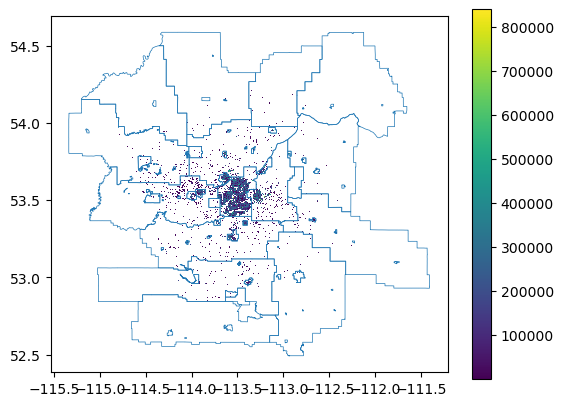

In [6]:
#plt.rcParams["figure.figsize"] = (5,6)

## the spatial join against the much wider areas of the census subdivisions 
## causes the default plotting area to be much wider than anticipated with the 
## Edmonton area geoemtry
nearby_speeds = speed_tiles.sjoin(edmonton_area.to_crs('epsg:4326'), how='inner') #epsg:4326
ax = nearby_speeds.plot(column='avg_d_kbps',legend=True)
nearby_census_subdivs.to_crs('epsg:4326').boundary.plot(ax=ax, linewidth=0.5)

Upload

<AxesSubplot: >

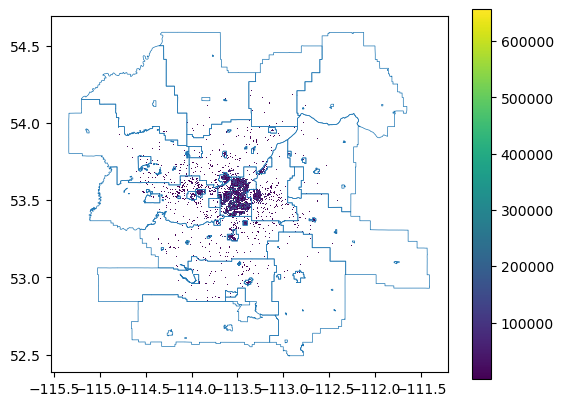

In [7]:
nearby_speeds = speed_tiles.sjoin(edmonton_area.to_crs('epsg:4326'), how='inner') #epsg:4326
ax = nearby_speeds.plot(column='avg_u_kbps',legend=True)
nearby_census_subdivs.to_crs('epsg:4326').boundary.plot(ax=ax, linewidth=0.5)

<AxesSubplot: >

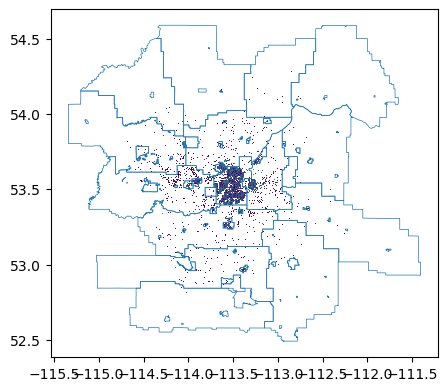

In [52]:
## the spatial join against the much wider areas of the census subdivisions 
## causes the default plotting area to be much wider than anticipated with the 
## Edmonton area geoemtry
nearby_speeds = speed_tiles.sjoin(edmonton_area.to_crs('epsg:4326'), how='inner') #epsg:4326
ax = nearby_speeds.plot(column='avg_d_kbps')
nearby_census_subdivs.to_crs('epsg:4326').boundary.plot(ax=ax, linewidth=0.5)

In [53]:
# Census Info
subdiv_pops = statcan.census_subdivisions_populations()
subdiv_pops.DAPOP = pd.to_numeric(subdiv_pops.DAPOP, errors='coerce') #certain subdivisions have data flags instead of values
subdiv_pops

,CSDUID,GEO_NAME,DAPOP
381,1001105,"Portugal Cove South, T",150.0
635,1001113,"Trepassey, T",485.0
1016,1001120,"St. Shott's, T",65.0
1270,1001124,"Division No. 1, Subd. U, SNO",1625.0
1778,1001126,"Cape Broyle, T",490.0
...,...,...,...
7605014,6208047,"Kugaaruk, HAM",935.0
7605268,6208059,"Kugluktuk, HAM",1490.0
7605649,6208073,"Cambridge Bay, HAM",1770.0
7606157,6208081,"Gjoa Haven, HAM",1325.0


<AxesSubplot: >

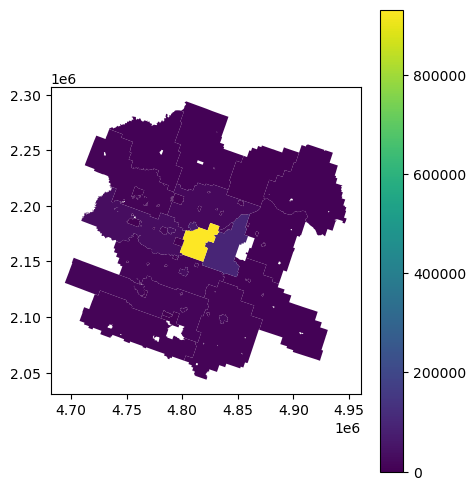

In [54]:
nearby_census_subdivs.CSDUID = nearby_census_subdivs.CSDUID.astype(int) ## coerce ID type to fully int instead of object
nearby_census_subdivs.merge(subdiv_pops, on='CSDUID', validate='1:1').plot(column='DAPOP', vmin=0, categorical=False, legend=True)

### Calgary Area

In [55]:
#Use a buffer to increase Calgary size, envelope creates a bounding box for use later.
calgary_area = statcan.boundary('population_centres').loc[lambda s:s.PCNAME=='Calgary'].copy()
calgary_area.geometry = calgary_area.buffer(50000).envelope #The StatCan CRS is in units of meters, so this is all tiles within 50 km of Calgary

In [56]:
nearby_census_subdivs = statcan.boundary('census_subdivisions').sjoin(calgary_area[['PCNAME','PCTYPE','PCCLASS','geometry']], how='inner')
del nearby_census_subdivs['index_right']
nearby_census_subdivs.sample(3)

,CSDUID,CSDNAME,CSDTYPE,PRUID,PRNAME,CDUID,CDNAME,CDTYPE,CCSUID,CCSNAME,...,SACCODE,SACTYPE,CMAUID,CMAPUID,CMANAME,CMATYPE,geometry,PCNAME,PCTYPE,PCCLASS
3985,4805012,Wheatland County,MD,48,Alberta,4805,Division No. 5,CDR,4805012,Wheatland County,...,996,4,None,None,None,None,"POLYGON ((4764817.771 1934584.723, 4764864.103...",Calgary,1,4
4460,4806001,Foothills No. 31,MD,48,Alberta,4806,Division No. 6,CDR,4806001,Foothills No. 31,...,996,4,None,None,None,None,"POLYGON ((4648614.243 1921740.991, 4648806.017...",Calgary,1,4
3272,4815027,Ghost Lake,SV,48,Alberta,4815,Division No. 15,CDR,4815015,Bighorn No. 8,...,999,7,None,None,None,None,"POLYGON ((4646885.271 1956478.631, 4647213.734...",Calgary,1,4


<AxesSubplot: >

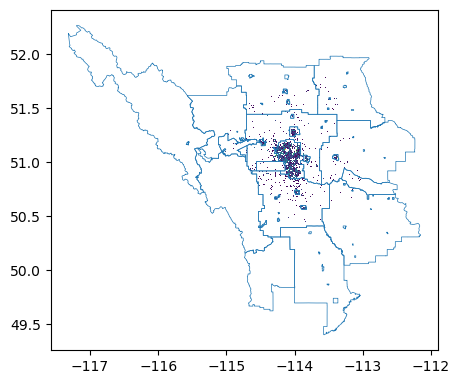

In [57]:
## the spatial join against the much wider areas of the census subdivisions 
## causes the default plotting area to be much wider than anticipated with the 
## calgary area geoemtry
nearby_speeds = speed_tiles.sjoin(calgary_area.to_crs('epsg:4326'), how='inner') #epsg:4326
ax = nearby_speeds.plot(column='avg_d_kbps')
nearby_census_subdivs.to_crs('epsg:4326').boundary.plot(ax=ax, linewidth=0.5)


### Census Info
Also some census data is available on populations.

In [58]:
subdiv_pops = statcan.census_subdivisions_populations()
subdiv_pops.DAPOP = pd.to_numeric(subdiv_pops.DAPOP, errors='coerce') #certain subdivisions have data flags instead of values
subdiv_pops

,CSDUID,GEO_NAME,DAPOP
381,1001105,"Portugal Cove South, T",150.0
635,1001113,"Trepassey, T",485.0
1016,1001120,"St. Shott's, T",65.0
1270,1001124,"Division No. 1, Subd. U, SNO",1625.0
1778,1001126,"Cape Broyle, T",490.0
...,...,...,...
7605014,6208047,"Kugaaruk, HAM",935.0
7605268,6208059,"Kugluktuk, HAM",1490.0
7605649,6208073,"Cambridge Bay, HAM",1770.0
7606157,6208081,"Gjoa Haven, HAM",1325.0


<AxesSubplot: >

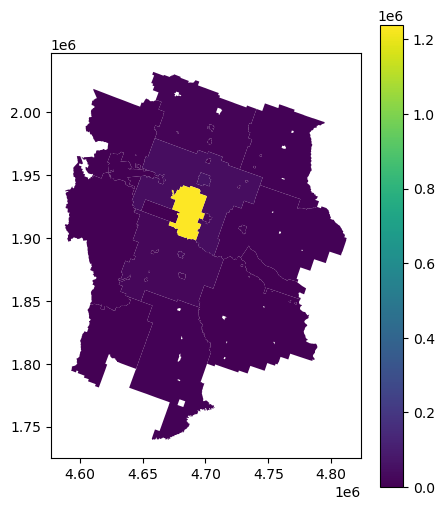

In [59]:
nearby_census_subdivs.CSDUID = nearby_census_subdivs.CSDUID.astype(int) ## coerce ID type to fully int instead of object
nearby_census_subdivs.merge(subdiv_pops, on='CSDUID', validate='1:1').plot(column='DAPOP', vmin=0, categorical=False, legend=True)

## Calculate Statistics

In [60]:
census_divs_speeds = statcan.boundary('census_divisions').to_crs('epsg:4326').sjoin(speed_tiles, how='left')

In [61]:
divs_pops = statcan.census_divisions_populations()
divs_pops.DAPOP = pd.to_numeric(divs_pops.DAPOP, errors='coerce') #certain subdivisions have data flags instead of values
divs_pops


,CDUID,GEO_NAME,DAPOP
254,1001,Division No. 1,270345.0
72644,1002,Division No. 2,20375.0
83820,1003,Division No. 3,15560.0
92075,1004,Division No. 4,20385.0
99568,1005,Division No. 5,42015.0
...,...,...,...
7589774,6105,Region 5,6980.0
7592441,6106,Region 6,20090.0
7597775,6204,Baffin,18985.0
7602347,6205,Keewatin,10415.0


In [62]:
census_speeds_agg = (census_divs_speeds.groupby('CDUID')['avg_d_kbps'].mean()/1000).rename('avg_d_mpbs')

[Text(0.5, 134.35749008818215, 'Easting (m)'),
 Text(38.34722222222222, 0.5, 'Northing (m)')]

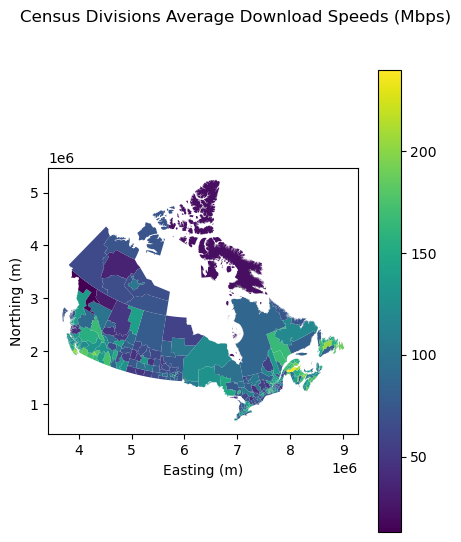

In [63]:
statcan.boundary('census_divisions').merge(census_speeds_agg, left_on="CDUID", right_index=True).plot(column='avg_d_mpbs', legend=True)
plt.gcf().suptitle("Census Divisions Average Download Speeds (Mbps)")
plt.gca().set(xlabel="Easting (m)", ylabel="Northing (m)")